# LSTM

## 라이브러리

In [2]:
import pandas as pd
import numpy as np
import re               # Regular Expression
import pickle           # 토큰화된 단어목록의 인덱스를 저장, 불러오기 위해 사용
from tqdm import tqdm   # 진행상황 Progress Bar를 위한 tqdm library

# 토크나이징/인코딩 관련 라이브러리
from eunjeon import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

# 모델링 관련 라이브러리
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 그래프 관련 라이브러리
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

데이터 불러오기

In [5]:
# 전처리 및 분할된 데이터셋 불러오기

X_train = np.array(pd.read_csv('./data/mecab/X_train.csv'))
y_train_1 = pd.DataFrame(pd.read_csv('./data/mecab/y_train.csv')['digit_1'])
y_train_2 = pd.DataFrame(pd.read_csv('./data/mecab/y_train.csv')['digit_2'].astype(object))
y_train_3 = pd.DataFrame(pd.read_csv('./data/mecab/y_train.csv')['digit_3'].astype(object))

X_valid = np.array(pd.read_csv('./data/mecab/X_valid.csv'))
y_valid_1 =  pd.DataFrame(pd.read_csv('./data/mecab/y_valid.csv')['digit_1'])
y_valid_2 =  pd.DataFrame(pd.read_csv('./data/mecab/y_valid.csv')['digit_2'].astype(object))
y_valid_3 =  pd.DataFrame(pd.read_csv('./data/mecab/y_valid.csv')['digit_3'].astype(object))

X_test = np.array(pd.read_csv('./data/mecab/X_test.csv'))


# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [6]:
# 한국표준산업분류 딕셔너리 불러오기

with open('./data/dictionary/digit_1_dict.pickle', 'rb') as handle:
    digit_1_dict = pickle.load(handle)

with open('./data/dictionary/digit_2_dict.pickle', 'rb') as handle:
    digit_2_dict = pickle.load(handle)

with open('./data/dictionary/digit_3_dict.pickle', 'rb') as handle:
    digit_3_dict = pickle.load(handle)

# 레이블 인코딩을 위한 산업분류 리스트, 데이터 프레임 만들기

digit_1_list = list(digit_1_dict.keys())
digit_1_df = pd.DataFrame([], columns=['digit_1'], index=[0])
for i in range(0, len(digit_1_dict)):
    digit_1_df.loc[i, 'digit_1'] = digit_1_list[i]

digit_2_list = list(digit_2_dict.keys())
digit_2_df = pd.DataFrame([], columns=['digit_2'], index=[0])
for i in range(0, len(digit_2_dict)):
    digit_2_df.loc[i, 'digit_2'] = digit_2_list[i]

digit_3_list = list(digit_3_dict.keys())
digit_3_df = pd.DataFrame([], columns=['digit_3'], index=[0])
for i in range(0, len(digit_3_dict)):
    digit_3_df.loc[i, 'digit_3'] = digit_3_list[i]

### 인코딩

In [7]:
# 대분류 원-핫 인코딩

ohe1 = preprocessing.OneHotEncoder(sparse=False, dtype=int)
ohe1.fit(digit_1_df)

y_train_1 = ohe1.transform(y_train_1)
y_valid_1 = ohe1.transform(y_valid_1)

# ohe1 객체에 담긴 인코딩 정보가 ohe1.pickle에 저장
with open('./data/mecab/ohe1.pickle', 'wb') as handle:
    pickle.dump(ohe1, handle)


# 중분류 원-핫 인코딩

ohe2 = preprocessing.OneHotEncoder(sparse=False, dtype=int)
ohe2.fit(digit_2_df)

y_train_2 = ohe2.transform(y_train_2)
y_valid_2 = ohe2.transform(y_valid_2)

# ohe2 객체에 담긴 인코딩 정보가 ohe2.pickle에 저장
with open('./data/mecab/ohe2.pickle', 'wb') as handle:
    pickle.dump(ohe2, handle)


# 소분류 원-핫 인코딩

ohe3 = preprocessing.OneHotEncoder(sparse=False, dtype=int)
ohe3.fit(digit_3_df)

y_train_3 = ohe3.transform(y_train_3)
y_valid_3 = ohe3.transform(y_valid_3)

# ohe3 객체에 담긴 인코딩 정보가 ohe3.pickle에 저장
with open('./data/mecab/ohe3.pickle', 'wb') as handle:
    pickle.dump(ohe3, handle)

## 대분류

In [19]:
embedding_dim = len(X_train[0])
hidden_units = len(X_train[0])
vocab_size = 35721

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(len(y_train_1[0]), activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('mecab_d1_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units), monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_1, epochs=20, callbacks=[es, mc], batch_size=100, validation_data=(X_valid, y_valid_1))


# 그래프 생성

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Epoch 1/20
1078/8000 [===>..........................] - ETA: 1:43 - loss: 1.0897 - acc: 0.7164

KeyboardInterrupt: 

In [21]:
loaded_model = load_model('./mecab_d1_ed10_hu10_sftmx_cc.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_1)[1]))

6250/6250 [==============================] - 22s 3ms/step - loss: 0.0825 - acc: 0.9777

 테스트 정확도: 0.9777


In [16]:
loaded_model = load_model('./mecab_d1_ed10_hu10_sftmx_cc.h5')
y_valid_1_predicted = loaded_model.predict(X_valid)
y_valid_1_predicted = ohe1.transform(ohe1.inverse_transform(y_valid_1_predicted))
X_valid = np.concatenate((y_valid_1_predicted, X_valid), axis=1)

In [21]:
len(X_valid[0])

31

## 중분류

In [18]:
X_train = np.concatenate((y_train_1, X_train), axis=1)

In [ ]:
len

In [20]:
len(X_train[0])

31

Epoch 1/20
8000/8000 [==============================] - 283s 35ms/step - loss: 0.4779 - acc: 0.8764 - val_loss: 0.2664 - val_acc: 0.9272

Epoch 00001: val_acc improved from -inf to 0.92721, saving model to ./data/model\mecab_d2_ed12_hu128_sftmx_cc.h5
Epoch 2/20
8000/8000 [==============================] - 296s 37ms/step - loss: 0.2297 - acc: 0.9360 - val_loss: 0.2338 - val_acc: 0.9353

Epoch 00002: val_acc improved from 0.92721 to 0.93529, saving model to ./data/model\mecab_d2_ed12_hu128_sftmx_cc.h5
Epoch 3/20
8000/8000 [==============================] - 298s 37ms/step - loss: 0.1959 - acc: 0.9440 - val_loss: 0.2220 - val_acc: 0.9381

Epoch 00003: val_acc improved from 0.93529 to 0.93806, saving model to ./data/model\mecab_d2_ed12_hu128_sftmx_cc.h5
Epoch 4/20
8000/8000 [==============================] - 292s 37ms/step - loss: 0.1773 - acc: 0.9487 - val_loss: 0.2179 - val_acc: 0.9395

Epoch 00004: val_acc improved from 0.93806 to 0.93955, saving model to ./data/model\mecab_d2_ed12_hu128

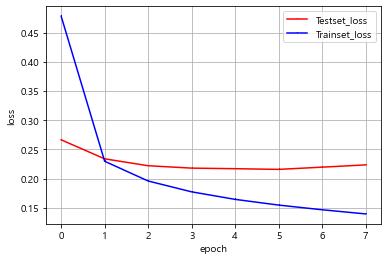

In [26]:
embedding_dim = len(X_train[0])
hidden_units = 128
vocab_size = 35721

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(len(y_train_2[0]), activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./data/model/mecab_d2_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units), monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_2, epochs=20, callbacks=[es, mc], batch_size=100, validation_data=(X_valid, y_valid_2))


y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [231]:
y_train_2[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [228]:
y_valid_2[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [229]:
X_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
       738,   3,  64,  40, 420], dtype=int64)

In [230]:
X_valid[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  95,  31, 285,
        95, 230,  95,  31,   2], dtype=int64)

In [27]:
loaded_model = load_model('./data/model/mecab_d2_ed12_hu12_sftmx_cc.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_2)[1]))

6250/6250 [==============================] - 21s 3ms/step - loss: 0.2609 - acc: 0.9322: 0s - loss: 0.2609 - acc:

 테스트 정확도: 0.9322


In [28]:
X_test

array([[   0,    0,    0, ...,  131,   72,    9],
       [   0,    0,    0, ...,   39,  263, 1366],
       [   0,    0,    0, ...,  275,  292,   52],
       ...,
       [   0,    0,    0, ...,   11, 1373,    9],
       [   0,    0,    0, ...,  595, 1077,   17],
       [   0,    0,    0, ..., 2252,   80,   31]], dtype=int64)

In [37]:
y_valid_2[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
loaded_model = load_model('./mecab_d2_ed31_hu31_sftmx_cc.h5')
y_valid_2_predicted = loaded_model.predict(X_valid)
y_valid_2_predicted = ohe2.transform(ohe2.inverse_transform(y_valid_2_predicted))
X_valid = np.concatenate((y_valid_2_predicted, X_valid), axis=1)

In [141]:
len(X_valid[0])

113

## 소분류

In [25]:
X_train = np.concatenate((y_train_2, X_train), axis=1)
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   35,    7,    5,    6, 1870,   35,   17], dtype=int64)

In [ ]:
len(X_train[0]

Epoch 1/10
8000/8000 [==============================] - 116s 14ms/step - loss: 1.7159 - acc: 0.6147 - val_loss: 0.8022 - val_acc: 0.8187

Epoch 00001: val_acc improved from -inf to 0.81873, saving model to ./data/model\mecab_d3_ed12_hu12_sftmx_cc.h5
Epoch 2/10
8000/8000 [==============================] - 116s 15ms/step - loss: 0.6372 - acc: 0.8528 - val_loss: 0.5636 - val_acc: 0.8690

Epoch 00002: val_acc improved from 0.81873 to 0.86896, saving model to ./data/model\mecab_d3_ed12_hu12_sftmx_cc.h5
Epoch 3/10
8000/8000 [==============================] - 113s 14ms/step - loss: 0.4860 - acc: 0.8842 - val_loss: 0.4897 - val_acc: 0.8842

Epoch 00003: val_acc improved from 0.86896 to 0.88416, saving model to ./data/model\mecab_d3_ed12_hu12_sftmx_cc.h5
Epoch 4/10
8000/8000 [==============================] - 113s 14ms/step - loss: 0.4233 - acc: 0.8974 - val_loss: 0.4569 - val_acc: 0.8897

Epoch 00004: val_acc improved from 0.88416 to 0.88972, saving model to ./data/model\mecab_d3_ed12_hu12_sft

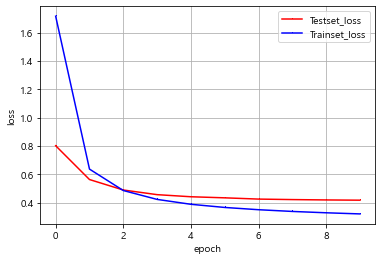

In [12]:

vocab_size = 35721
embedding_dim = len(X_train[0])
hidden_units = len(X_train[0])

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(232, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./data/model/mecab_d3_ed{}_hu{}_sftmx_cc.h5'.format(embedding_dim, hidden_units), monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_3, epochs=10, callbacks=[es, mc], batch_size=100, validation_data=(X_valid, y_valid_3))

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [132]:
with open('./data/mecab/le1.pickle', 'rb') as handle:
    le1 = pickle.load(handle)

digit_1_list = list(digit_1_dict.keys())
y_train_1 = le1.transform(y_train_1)
y_train_1 = np_utils.to_categorical(y_train_1, num_classes=len(digit_1_list))
X_train = np.concatenate((y_train_1, X_train), axis=1).astype('int32')

digit_2_list = list(digit_2_dict.keys())
y_train_2 = le2.transform(y_train_2)
y_train_2 = np_utils.to_categorical(y_train_2, num_classes=len(digit_2_list))
X_train = np.concatenate((y_train_2, X_train), axis=1).astype('int32')

In [136]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    8,    4,
         11, 1639,    9])

In [28]:
len(X_train[0])

108

In [146]:
len(X_valid[0])

108

In [23]:
loaded_model = load_model('./data/model/mecab_d3_ed12_hu12_sftmx_cc.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_3)[1]))

1947/6250 [========>.....................] - ETA: 8s - loss: 0.4187 - acc: 0.8982

KeyboardInterrupt: 

In [139]:
loaded_model = load_model('./mecab_d1_ed100_hu128_ep10_bs128_sftmx_cc.h5')
y_valid_1_predicted = loaded_model.predict(X_valid)

temp_list_1 = []

for i in tqdm(range(0, len(y_valid_1_predicted))):
    temp_list_1.append([le1.inverse_transform([y_valid_1_predicted[i].argmax()])[0]])
temp_list_1 = le1.transform(temp_list_1)
temp_list_1 = np_utils.to_categorical(temp_list_1)

X_valid = np.concatenate((temp_list_1, X_valid), axis=1).astype('int32')
X_valid[0]

100%|██████████| 200000/200000 [00:14<00:00, 14095.49it/s]
C:\Users\Huitaek\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 32, 21,  3, 16, 18, 10,  2])

In [159]:
X_train[2]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 65, 75, 86, 33, 51, 33,  2], dtype=int64)

In [150]:
X_train.shape

(800000, 113)

In [151]:
X_valid.shape

(200000, 113)

In [160]:
loaded_model = load_model('./mecab_d2_ed{}_hu{}_sftmx_cc.h5.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_3)[1]))

6250/6250 [==============================] - 268s 43ms/step - loss: 0.7543 - acc: 0.9139

 테스트 정확도: 0.9139


## 최종 예측 모델 결합, 답안 제출

In [29]:
X_test = np.array(pd.read_csv('./data/mecab/X_test.csv'))

In [32]:
loaded_model = load_model('./data/model/mecab_d1_ed10_hu10_sftmx_cc.h5')
y_test_1_predicted = loaded_model.predict(X_test)

In [33]:
y_test_1_predicted_pl = ohe1.transform(ohe1.inverse_transform(y_test_1_predicted))
X_test = np.concatenate((y_test_1_predicted_pl, X_test), axis=1)

loaded_model = load_model('./data/model/mecab_d2_ed31_hu31_sftmx_cc.h5')
y_test_2_predicted = loaded_model.predict(X_test)

In [34]:
y_test_2_predicted_pl = ohe2.transform(ohe2.inverse_transform(y_test_2_predicted))
X_test = np.concatenate((y_test_2_predicted_pl, X_test), axis=1)
 
loaded_model = load_model('./data/model/mecab_d3_ed108_hu108_sftmx_cc.h5')
y_test_3_predicted = loaded_model.predict(X_test)

In [35]:
# 인코딩된 예측값 원래 형태로 원상 복구

temp_list_1 = []
temp_list_2 = []
temp_list_3 = []

for i in tqdm(range(0, len(y_test_1_predicted))):
    temp_list_1.append(ohe1.inverse_transform([y_test_1_predicted[i]])[0][0])
    temp_list_2.append(ohe2.inverse_transform([y_test_2_predicted[i]])[0][0])
    temp_list_3.append(ohe3.inverse_transform([y_test_3_predicted[i]])[0][0])

100%|██████████| 100000/100000 [00:31<00:00, 3133.96it/s]


In [36]:
temp_list_1

['I',
 'G',
 'S',
 'C',
 'I',
 'C',
 'I',
 'C',
 'S',
 'C',
 'C',
 'S',
 'C',
 'Q',
 'M',
 'S',
 'G',
 'G',
 'G',
 'M',
 'C',
 'G',
 'Q',
 'S',
 'C',
 'S',
 'G',
 'L',
 'L',
 'R',
 'P',
 'G',
 'I',
 'C',
 'S',
 'I',
 'G',
 'J',
 'C',
 'Q',
 'G',
 'C',
 'G',
 'I',
 'C',
 'H',
 'I',
 'G',
 'M',
 'G',
 'G',
 'G',
 'C',
 'G',
 'C',
 'S',
 'P',
 'C',
 'C',
 'G',
 'G',
 'C',
 'S',
 'E',
 'F',
 'S',
 'I',
 'S',
 'Q',
 'G',
 'S',
 'L',
 'S',
 'S',
 'G',
 'P',
 'G',
 'S',
 'I',
 'R',
 'G',
 'I',
 'S',
 'G',
 'G',
 'S',
 'G',
 'S',
 'P',
 'S',
 'G',
 'G',
 'C',
 'C',
 'S',
 'Q',
 'M',
 'G',
 'J',
 'F',
 'G',
 'G',
 'G',
 'G',
 'L',
 'M',
 'S',
 'S',
 'I',
 'Q',
 'S',
 'Q',
 'K',
 'S',
 'S',
 'F',
 'G',
 'G',
 'F',
 'M',
 'C',
 'C',
 'N',
 'G',
 'C',
 'I',
 'H',
 'J',
 'P',
 'S',
 'G',
 'O',
 'G',
 'I',
 'R',
 'S',
 'S',
 'G',
 'L',
 'P',
 'S',
 'G',
 'P',
 'L',
 'C',
 'G',
 'H',
 'I',
 'A',
 'I',
 'C',
 'P',
 'L',
 'S',
 'G',
 'C',
 'G',
 'G',
 'K',
 'L',
 'C',
 'G',
 'G',
 'F',
 'G',
 'R',
 'C'

In [37]:
# 답안 작성용 파일에 대분류/중분류/소분류 예측 컬럼 삽입 후 csv 파일로 저장

test_data = pd.read_csv('./data/test.csv')

test_data['digit_1'] = temp_list_1
test_data['digit_2'] = temp_list_2
test_data['digit_3'] = temp_list_3

test_data.to_csv('./data/output/답안 작성용 파일.csv', encoding='CP949', index=False)

In [38]:
test_data

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal
0,id_000001,I,56,561,치킨전문점에서,고객의주문에의해,치킨판매
1,id_000002,G,46,466,산업공구,다른 소매업자에게,철물 수공구
2,id_000003,S,94,949,절에서,신도을 대상으로,불교단체운영
3,id_000004,C,30,302,영업장에서,고객요구로,자동차튜닝
4,id_000005,I,56,562,실내포장마차에서,접객시설을 갖추고,"소주,맥주제공"
...,...,...,...,...,...,...,...
99995,id_099996,G,47,472,사업장에서,일반인대상으로,버섯농장
99996,id_099997,Q,86,862,한의원에서,외래환자위주고,치료
99997,id_099998,G,47,478,일반점포에서,소비자에게,그림판매
99998,id_099999,R,90,902,사업장에서,일반인.학생대상으로,학습공간제공


In [179]:
# 결과값 검정 용이를 위해 산업분류 사전과 매핑한 csv 저장

translated_data = test_data.copy()
translated_data['digit_1'] = translated_data['digit_1'].replace(digit_1_dict)
translated_data['digit_2'] = translated_data['digit_2'].replace(digit_2_dict)
translated_data['digit_3'] = translated_data['digit_3'].replace(digit_3_dict)

translated_data.to_csv('./data/output/final_translated.csv', encoding='CP949', index=False)

In [180]:
translated_data

,AI_id,digit_1,digit_2,digit_3,text_obj,text_mthd,text_deal
0,id_000001,숙박 및 음식점업(55~56),음식점 및 주점업,음식점업,치킨전문점에서,고객의주문에의해,치킨판매
1,id_000002,도매 및 소매업(45~47),도매 및 상품 중개업,"건축 자재, 철물 및 난방장치 도매업",산업공구,다른 소매업자에게,철물 수공구
2,id_000003,"협회 및 단체, 수리 및 기타 개인 서비스업(94~96)",협회 및 단체,기타 협회 및 단체,절에서,신도을 대상으로,불교단체운영
3,id_000004,제조업(10~34),자동차 및 트레일러 제조업,자동차 및 모터사이클 수리업,영업장에서,고객요구로,자동차튜닝
4,id_000005,숙박 및 음식점업(55~56),음식점 및 주점업,주점 및 비알코올 음료점업,실내포장마차에서,접객시설을 갖추고,"소주,맥주제공"
...,...,...,...,...,...,...,...
99995,id_099996,도매 및 소매업(45~47),소매업; 자동차 제외,음ㆍ식료품 및 담배 소매업,사업장에서,일반인대상으로,버섯농장
99996,id_099997,보건업 및 사회복지 서비스업(86~87),보건업,의원,한의원에서,외래환자위주고,치료
99997,id_099998,도매 및 소매업(45~47),소매업; 자동차 제외,기타 상품 전문 소매업,일반점포에서,소비자에게,그림판매
99998,id_099999,"예술, 스포츠 및 여가관련 서비스업(90~91)","창작, 예술 및 여가관련 서비스업","도서관, 사적지 및 유사 여가관련 서비스업",사업장에서,일반인.학생대상으로,학습공간제공


In [78]:
# 대분류/중분류/소분류 예측 모델 불러오기, 불러온 모델로 test data 예측

test_data = np.array(pd.read_csv('./data/mecab/test_data.csv'))

loaded_model_1 = load_model('./data/model/digit1_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_1_predicted = loaded_model_1.predict(test_data)

loaded_model_2 = load_model('./data/model/digit2_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_2_predicted = loaded_model_2.predict(test_data)

loaded_model_3 = load_model('./data/model/digit3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_3_predicted = loaded_model_3.predict(test_data)

In [108]:
# 인코딩된 예측값 원래 형태로 원상 복구

temp_list_1 = []
temp_list_2 = []
temp_list_3 = []

for i in tqdm(range(0, len(y_test_1_predicted))):
    temp_list_1.append(le1.inverse_transform([y_test_1_predicted[i].argmax()])[0])
    temp_list_2.append(le2.inverse_transform([y_test_2_predicted[i].argmax()])[0])
    temp_list_3.append(le3.inverse_transform([y_test_3_predicted[i].argmax()])[0])

100%|██████████| 100000/100000 [00:11<00:00, 8534.98it/s]


In [117]:
# 답안 작성용 파일에 대분류/중분류/소분류 예측 컬럼 삽입 후 csv 파일로 저장

test_data = pd.read_csv('./data/test.csv')

test_data['digit_1'] = temp_list_1
test_data['digit_2'] = temp_list_2
test_data['digit_3'] = temp_list_3

test_data.to_csv('./data/output/답안 작성용 파일.csv', encoding='CP949', index=False)

In [124]:
# 결과값 검정 용이를 위해 산업분류 사전과 매핑한 csv 저장

translated_data = test_data.copy()
translated_data['digit_1'] = translated_data['digit_1'].replace(digit_1_dict)
translated_data['digit_2'] = translated_data['digit_2'].replace(digit_2_dict)
translated_data['digit_3'] = translated_data['digit_3'].replace(digit_3_dict)

translated_data.to_csv('./data/output/final_translated.csv', encoding='CP949', index=False)

## 예측기

### 대분류 예측기

### 중분류 예측기

### 소분류 예측기

In [ ]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')


def sentiment_predict2(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le3.inverse_transform([label.argmax()])[0])
  print(digit_3_dict[le3.inverse_transform([label.argmax()])[0]])

In [ ]:
sentiment_predict2('정비회사에서|자동차의전반적인|정비 종합수리서비스')

정비회사에서자동차의전반적인정비 종합수리서비스
['정비', '회사', '에서', '자동차', '의', '전반', '적', '인', '정비', '종합', '수리', '서비스']
['정비', '회사', '에서', '자동차', '의', '전반', '적', '인', '정비', '종합', '수리', '서비스']
[[271, 291, 43, 2169, 175, 271, 228, 46, 2]]
[[   0    0    0    0    0    0  271  291   43 2169  175  271  228   46
     2]]
[[2.25543495e-08 6.05824141e-07 1.46671744e-10 1.06609705e-05
  7.70816674e-11 1.70350845e-08 1.28942315e-10 1.73955748e-08
  2.46597381e-10 1.65171571e-10 2.27767916e-10 3.23220062e-10
  1.34238731e-10 1.91093894e-11 5.29234256e-09 2.25108465e-09
  1.76460874e-10 2.92087021e-09 1.63499308e-07 2.07227679e-10
  4.81583350e-11 1.70529315e-08 4.16814459e-08 2.74717887e-11
  7.91270249e-09 1.07565179e-09 1.90920557e-10 1.01880504e-09
  1.30524966e-10 1.16911991e-09 2.71794809e-09 1.13763790e-11
  4.21847973e-10 1.15860023e-12 2.39433307e-10 3.19270010e-09
  1.26816024e-09 6.26243875e-08 7.20114857e-09 2.93753466e-10
  6.30222132e-08 5.38868399e-08 8.70925376e-09 3.78718461e-08
  1.62408498e-09 8.9349

In [ ]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit2_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le2.inverse_transform([label.argmax()])[0])
  print(digit_2_dict[le2.inverse_transform([label.argmax()])[0]])

In [ ]:
sentiment_predict('영어학원|일반학생대상|영어교육')

영어학원일반학생대상영어교육
['영어', '학원', '일반', '학생', '대상', '영어', '교육']
['영어', '학원', '일반', '학생', '대상', '영어', '교육']
[[106, 30, 10, 38, 1, 106, 28]]
[[  0   0   0   0   0   0   0   0 106  30  10  38   1 106  28]]
[[3.3901244e-09 2.0897637e-08 3.8126666e-09 3.0675029e-10 2.2629222e-10
  7.9605428e-08 3.2770386e-10 8.7994927e-08 7.0510360e-08 2.0747966e-10
  2.8677161e-07 4.2352216e-08 2.1015593e-08 6.9544690e-08 1.5907085e-09
  7.6828748e-08 1.1855049e-10 3.5715878e-08 2.3497962e-07 2.0660003e-08
  3.3980680e-07 8.5391652e-11 4.7124776e-10 4.9496984e-09 2.7503464e-07
  1.2095218e-09 3.9833288e-09 6.8410988e-09 2.5822013e-09 3.7302346e-08
  2.2491537e-07 3.1255757e-07 4.7099481e-12 5.2456600e-10 2.8596964e-10
  2.7771394e-08 7.6750064e-09 1.4437527e-06 1.7732052e-07 8.7860883e-09
  2.1529750e-06 2.5718451e-05 3.7065444e-09 8.7804473e-08 8.3038493e-10
  5.5193863e-09 1.8413728e-07 5.3079219e-07 3.3821743e-07 6.4629234e-07
  3.9017416e-09 2.1560042e-07 1.5189957e-07 2.1014881e-07 1.7168924e-08
  9.9406627

In [ ]:
loaded_model = load_model('./best_model2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test_3)[1]))

6250/6250 [==============================] - 51s 8ms/step - loss: 13.4765 - acc: 0.0036

 테스트 정확도: 0.0036


In [ ]:
# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
tokenizer.word_index

{"'����'": 1,
 "'���'": 2,
 "'��'": 3,
 "'������'": 4,
 "'�����'": 5,
 "'�ϲ�'": 6,
 "'�ü�'": 7,
 "'�ǹ�'": 8,
 "'�һ���'": 9,
 "'�ϲ���'": 10,
 "'�ҹ�'": 11,
 "'��û'": 12,
 "'ȭ��'": 13,
 "'��ǰ'": 14,
 "'�ƿ�'": 15,
 "'ȭ���ڵ���'": 16,
 "'�ε���'": 17,
 "'�߰�'": 18,
 "'�°�'": 19,
 "'�����ý�'": 20,
 "'�繫��'": 21,
 "'�п�'": 22,
 "'�ڵ���'": 23,
 "'ŀ��'": 24,
 "'�л�'": 25,
 "'�ҹž���'": 26,
 "'ü��'": 27,
 "'��ȸ'": 28,
 "'ȱ��'": 29,
 "'�̿��'": 30,
 "'ȯ��'": 31,
 "'��ʈ'": 32,
 "'ö��'": 33,
 "'��ġ'": 34,
 "'�ܷ�'": 35,
 "'�\ueff5'": 36,
 "'ġ��'": 37,
 "'�̿�'": 38,
 "'����ʈ'": 39,
 "'�ǽ�'": 40,
 "'�ĸ�'": 41,
 "'��ü'": 42,
 "'�ѽ�'": 43,
 "'�䱸'": 44,
 "'��������'": 45,
 "'��ź'": 46,
 "'�ֹ�'": 47,
 "'�ǰ�'": 48,
 "'��ȭ'": 49,
 "'ġų'": 50,
 "'�\u2d76��'": 51,
 "'�ǿ�'": 52,
 "'�뷡��'": 53,
 "'���ķ�ǰ'": 54,
 "'ȸ��'": 55,
 "'�ĵ�'": 56,
 "'�\uee30��'": 57,
 "'ö'": 58,
 "'�ݼ�'": 59,
 "'ȭ��ǰ'": 60,
 "'�ǻ�'": 61,
 "'�߹�'": 62,
 "'��ź��'": 63,
 "'�ְ�'": 64,
 "'��ǻ��'": 65,
 "'�ӵ�'": 66,
 "'�ǳ�'": 67,
 "'�\u0530�'": 6

In [ ]:
mecab = Mecab()
loaded_model = load_model('./ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords.csv')
stopwords = list(stopwords['stopwords'])


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le1.inverse_transform([label.argmax()])[0])
  print(digit_1_dict[le1.inverse_transform([label.argmax()])[0]])

In [ ]:
sentiment_predict("카센터에서|자동차부분정비|타이어오일교환")

카센터에서자동차부분정비타이어오일교환
['카센터', '에서', '자동차', '부분', '정비', '타이어', '오', '일', '교환']
['카센터', '에서', '자동차', '부분', '정비', '타이어', '오', '일', '교환']
[[607, 40, 210, 264, 257, 931]]
[[  0   0   0   0   0   0   0   0   0 607  40 210 264 257 931]]
[[4.1274594e-05 5.7865927e-06 5.8053585e-04 1.6885963e-07 6.4396788e-04
  6.3920606e-06 1.3797742e-05 9.4412053e-06 1.1517714e-06 7.4284566e-05
  2.0624391e-06 2.2640058e-06 3.1059209e-04 4.9767538e-04 5.8264245e-04
  1.5870976e-03 9.9255306e-01 3.3423206e-05 3.0544442e-03]]
Q
보건업 및 사회복지 서비스업(86~87)


In [ ]:
# y_test_1_predicted = pd.DataFrame(loaded_model.predict(X_test))